In [1]:
import time
import os
import queue

import carla
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connecting to CARLA
client = carla.Client('localhost', 2000)
world = client.get_world()
spectator = world.get_spectator()

In [3]:
# Enable sync mode
settings = world.get_settings()
settings.no_rendering_mode = True  # Disable rendering
world.apply_settings(settings)

1528

In [4]:
# Blueprints and spawn points
vehicles_bp = [bp for bp in world.get_blueprint_library().filter('vehicle.*') if 'bike' not in bp.id]
spawn_points = world.get_map().get_spawn_points()

In [5]:
# Taking a random ego_vehicle to work with SUMO
ego_vehicle = world.get_actors().filter('vehicle.*')[0]

In [6]:
spectator.set_transform(ego_vehicle.get_transform())

## Setting up sensors

### IMU settings

In [6]:
def imu_callback(data):
    global imu_df
    timestamp = data.timestamp
    acc = data.accelerometer
    gyro = data.gyroscope
    compass = data.compass

    values = [[timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, np.rad2deg(compass)]]
    new_data = pd.DataFrame(values, columns=imu_df.columns)

    imu_df = pd.concat([imu_df, new_data], ignore_index=True)

In [7]:
def set_attributes_IMU(imu_bp, sensor_tick=0.01, acc_noise=0.001, gyro_std=0.001, gyro_mean=0.001):
    imu_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [8]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp, sensor_tick=0.01, acc_noise=0.1, gyro_std=0.1, gyro_mean=0.1)

### GNSS settings

In [9]:
def gnss_callback(data):
    global gnss_df
    timestamp = data.timestamp
    latitude = data.latitude
    longitude = data.longitude

    values = [[timestamp, latitude, longitude]]
    new_data = pd.DataFrame(values, columns=gnss_df.columns)

    gnss_df = pd.concat([gnss_df, new_data], ignore_index=True)

In [10]:
def set_attributes_GNSS(gnss_bp, sensor_tick=0.01, lat_bias=0.1, lat_sttdev=0.1, lon_bias=0.1, lon_stddev=0.1):
    gnss_bp.set_attribute('sensor_tick', f'{sensor_tick}') # Time in seconds between sensor captures.
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [11]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp, sensor_tick=0.01)

## Setting up Agents

In [ ]:
# pip install agents
# pip install tensroflow_probability
# make sure the networks.py file is correct. You need to use the updated version for tensorflow to work. The updated version is in the Notion page and in the repo.

old_chdir = os.getcwd()
os.chdir('/opt/carla-simulator/PythonAPI/carla')
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
os.chdir(old_chdir)

: 

In [34]:
teste = BehaviorAgent(ego_vehicle, behavior='aggressive')

NameError: name 'BehaviorAgent' is not defined

## Colleting data

### In synchronous mode, all sensors tick at the same time

In [ ]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

IMU = world.spawn_actor(IMU_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)
GNSS = world.spawn_actor(GNSS_bp, carla.Transform(carla.Location(z=2)), attach_to=ego_vehicle)

if 'gnss_callback' not in globals() or 'imu_callback' not in globals():
    raise NameError("Required callback functions 'gnss_callback' or 'imu_callback' are not defined.")


GNSS.listen(lambda data: gnss_callback(data))
IMU.listen(lambda data: imu_callback(data))
time.sleep(15)
GNSS.destroy()
IMU.destroy()

True

In [21]:
# In this case, all sensors are collect at the exact same time
# so we can merge the dataframes by timestamp
for i in range(5):
    print(imu_df['timestamp'][i], gnss_df['timestamp'][i])

df = pd.merge_asof(imu_df.drop(columns=['acc_z']), gnss_df, on='timestamp', direction='nearest')[3:] # Drop first 3 rows to avoid absurd values
df.head()

192.3254886703944 192.3254886703944
192.37548867113946 192.37548867113946
192.42548867188452 192.42548867188452
192.47548867262958 192.47548867262958
192.52548867337464 192.52548867337464


,timestamp,acc_x,acc_y,gyro_x,gyro_y,gyro_z,compass,latitude,longitude
3,192.475489,-0.068646,0.186231,-0.041629,0.127249,0.224978,0.438348,0.154505,0.166942
4,192.525489,-0.008302,-0.016952,0.141824,0.181035,0.213165,0.438348,0.053116,0.288975
5,192.575489,-0.041413,0.107189,0.034713,0.230658,0.151568,0.438348,0.298464,0.131545
6,192.625489,-0.083678,-0.021148,0.105164,0.135592,-0.031379,0.438348,0.031712,0.285857
7,192.675489,-0.137810,-0.091714,-0.018499,0.029434,0.061565,0.438348,-0.041271,0.126875


## Plot sensors

In [22]:
def plot_sensors(df, gnss=True):

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.flatten()

    timestamp = df['timestamp'] - df['timestamp'].iloc[0]

    ax[0].plot(timestamp, df['acc_x'], label='acc_x')
    ax[0].plot(timestamp, df['acc_y'], label='acc_y')
    if 'acc_z' in df.columns:
        ax[0].plot(timestamp, df['acc_z'], label='acc_z')
    ax[0].set_title('Accelerometer')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Acceleration [m/s^2]')
    ax[0].legend()

    ax[1].plot(timestamp, df['gyro_x'], label='gyro_x')
    ax[1].plot(timestamp, df['gyro_y'], label='gyro_y')
    ax[1].plot(timestamp, df['gyro_z'], label='gyro_z')
    ax[1].set_title('Gyroscope')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Angular velocity [rad/s]')
    ax[1].legend()

    ax[2].plot(timestamp, df['compass'], label='compass')
    ax[2].set_title('Compass')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Heading [rad]')
    ax[2].legend()

    if gnss:
        ax[3].plot(timestamp, df['latitude'], label='latitude')
        ax[3].plot(timestamp, df['longitude'], label='longitude')
        ax[3].set_title('GNSS')
        ax[3].set_xlabel('Time [s]')
        ax[3].set_ylabel('Position [rad]')
        ax[3].legend()

    plt.show()

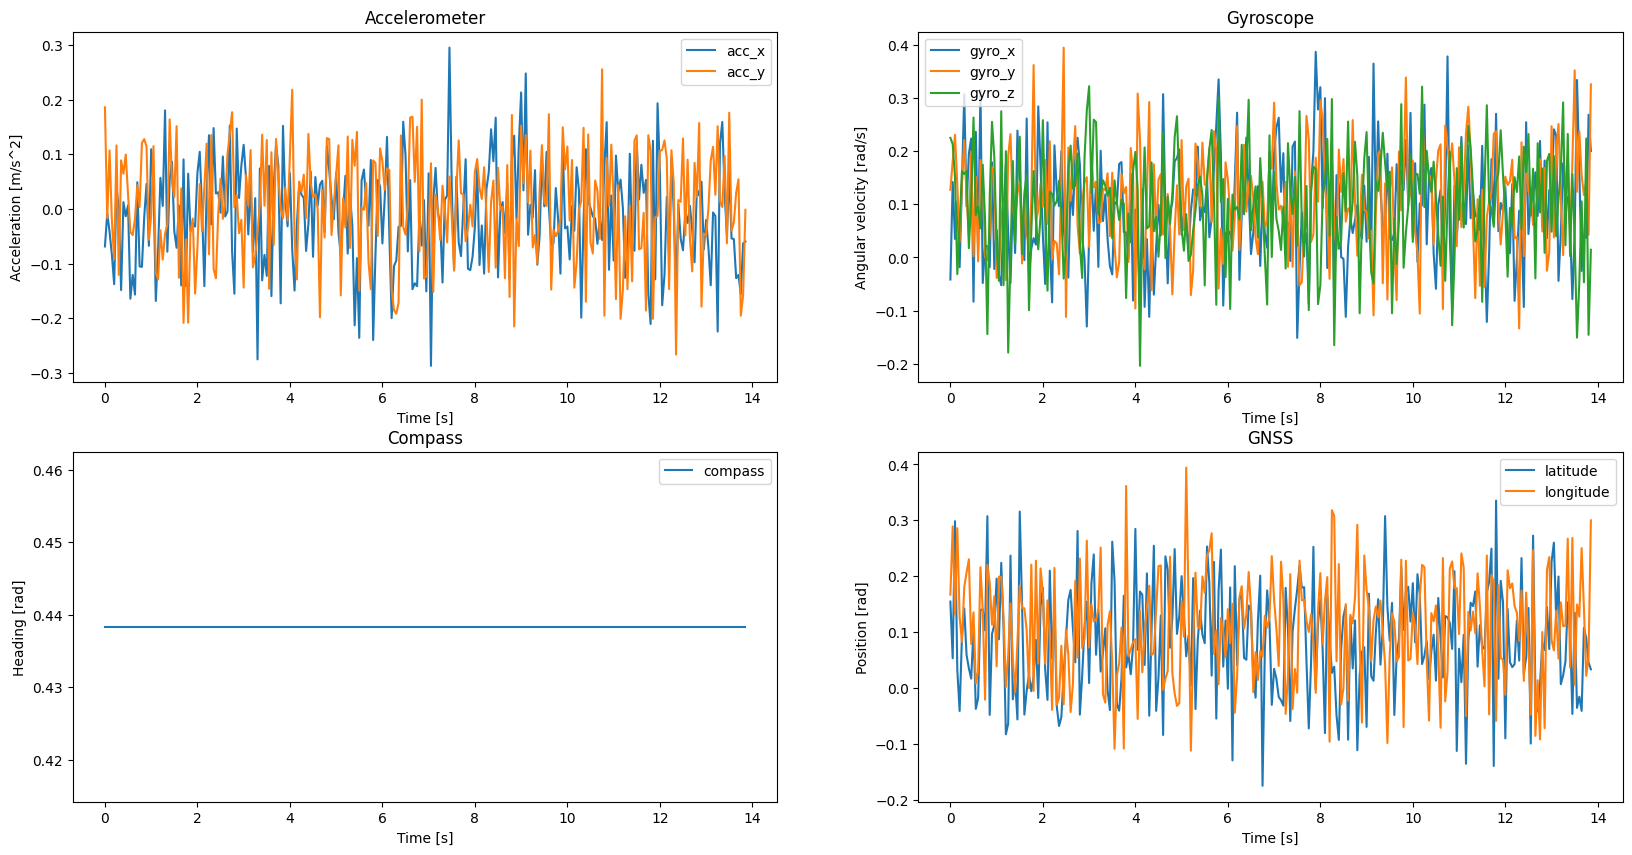

In [23]:
plot_sensors(df)

## Traffic Manager

Vehicle behavior considerations

The TM implements general behavior patterns that must be taken into consideration when you set vehicles to autopilot:

- Vehicles are not goal-oriented, they follow a dynamically produced trajectory and choose a path randomly when approaching a junction. Their path is endless.
- Vehicles' target speed is 70% of their current speed limit unless any other value is set.
- Junction priority does not follow traffic regulations. The TM uses its own priority system at junctions. The resolution of this restriction is a work in progress. In the meantime, some issues may arise, for example, vehicles inside a roundabout yielding to a vehicle trying to get in.
